Taken from https://www.kaggle.com/code/sugghi/training-3rd-place-solution

# Setup

In [24]:
%reload_ext autoreload
%autoreload 2

In [25]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import config

from feature_engineering import *
from training import *

import pickle
import gc

from tqdm import tqdm

n_fold = 7
seed0 = 8586
use_supple_for_train = True

# If True, the period used to evaluate Public LB will not be used for training.
# Set to False on final submission.
not_use_overlap_to_train = False

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 350)

lags = [60,300,900]

In [26]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }

# Data Processing

In [27]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [28]:
# no keys required for crypto data
client = CryptoHistoricalDataClient()

symbol = "BTC/USD"
request_params = CryptoBarsRequest(
    # symbol_or_symbols=["BTC/USD", "ETH/USD"],
    symbol_or_symbols=symbol,
    timeframe=TimeFrame.Hour,
    start=datetime.strptime("2017-03-01", '%Y-%m-%d')
)

bars = client.get_crypto_bars(request_params)

In [29]:
# convert to dataframe
btc = bars.df.loc[symbol]
btc = btc[['close']].copy()
btc.fillna(method='ffill', limit=100)
btc = reduce_mem_usage(btc)

df_train, df_val, df_test = (
    btc.loc[:config.TRAIN_END_DATE].copy(), 
    btc.loc[config.VAL_START_DATE:config.VAL_END_DATE].copy(),
    btc.loc[config.TEST_START_DATE:].copy()
)

Memory usage of dataframe is 0.39 MB
Memory usage after optimization is: 0.29 MB
Decreased by 25.0%


In [49]:
hours_ahead = 24
df_test['target'] = df_test['close'].rolling(window=hours_ahead).apply(lambda x: x.tolist()).shift(-hours_ahead + 1)


TypeError: must be real number, not list

# Feature Engineering

In [30]:
df_proc = get_features(btc)
df_proc

C:\Users\User\Documents\1 Projects\bitcoin_price_predictor\feature_engineering.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{lag}"] = df["close"].shift(lag)
C:\Users\User\Documents\1 Projects\bitcoin_price_predictor\feature_engineering.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{lag}"] = df["close"].shift(lag)
C:\Users\User\Documents\1 Projects\bitcoin_price_predictor\feature_engineering.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

,close,log_close/mean_60,log_return_60,mean_close/mean_60,mean_log_returns_60,log_close/mean_60-mean_close/mean_60,log_return_60-mean_log_returns_60,log_close/mean_300,log_return_300,mean_close/mean_300,mean_log_returns_300,log_close/mean_300-mean_close/mean_300,log_return_300-mean_log_returns_300,log_close/mean_900,log_return_900,mean_close/mean_900,mean_log_returns_900,log_close/mean_900-mean_close/mean_900,log_return_900-mean_log_returns_900,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,...,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,target
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-15 09:00:00+00:00,38638.250000,0.047538,0.108208,0.023853,1.489534e-10,0.023685,0.108208,0.067505,0.157509,0.121317,2.979069e-10,-0.053812,0.157509,10.561998,0.040444,0.364721,4.766510e-09,10.197277,0.040444,38261.460938,38436.921875,38000.000000,37800.019531,38419.769531,38669.949219,39219.519531,39118.320312,39425.910156,39127.101562,38932.648438,38767.269531,39319.371094,39837.339844,39311.238281,39403.218750,39240.449219,39506.679688,39574.878906,38994.078125,38275.000000,38361.769531,38494.500000,37972.750000,38406.128906,38224.589844,37861.808594,37546.570312,37501.000000,37037.511719,37428.949219,37438.890625,37792.710938,37

In [31]:
feature_names = df_proc.drop('target', axis=1).columns.tolist()
# TODO - he has 174 total... but 19 x 14 = 266
print(len(feature_names))
assert 'target' not in feature_names

355


# Training

Training model for BTC
Entering time series cross-validation loop

Processing split 1/5
Number of train data: 4186
Number of val data: 3848
Trained model saved to 'trained_model_id_fold0.pkl'

Processing split 2/5
Number of train data: 8370
Number of val data: 3848
Trained model saved to 'trained_model_id_fold1.pkl'

Processing split 3/5
Number of train data: 12554
Number of val data: 3848
Trained model saved to 'trained_model_id_fold2.pkl'

Processing split 4/5
Number of train data: 16738
Number of val data: 3848
Trained model saved to 'trained_model_id_fold3.pkl'

Processing split 5/5
Number of train data: 20922
Number of val data: 3848
Trained model saved to 'trained_model_id_fold4.pkl'


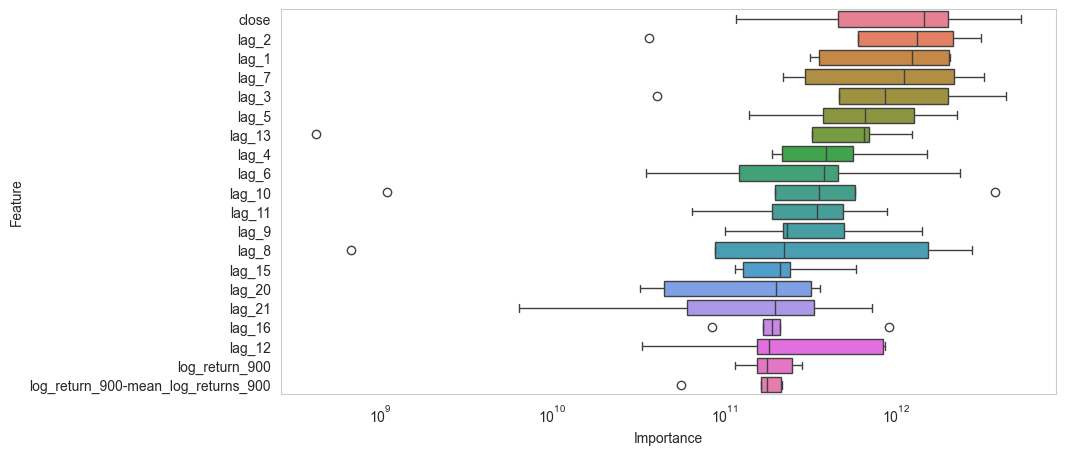

OOF corr score of BTC is 0.9004


In [32]:
print(f"Training model for BTC")

oof_pred, oof_valid = train_and_evaluate_time_series_model(df_proc, feature_names, params)

corr_ = corr_score(np.array(oof_pred), np.array(oof_valid))

print(f'OOF corr score of BTC is {corr_:.4f}')
print('')
print('')

In [33]:
np.corrcoef(np.array(oof_pred), np.array(oof_valid))[0, 1]

0.900428701348794

In [34]:
y_pred_baseline, y_val_baseline = BaselinePreviousHour().run_embargo_cv(df_proc)
y_pred_baseline


Processing split 1/5

Processing split 2/5

Processing split 3/5

Processing split 4/5

Processing split 5/5


[32650.53,
 32605.94,
 32690.24,
 32636.77,
 32586.82,
 32488.52,
 32325.57,
 32334.95,
 32343.96,
 32307.0,
 32444.84,
 32558.1,
 32482.64,
 32319.8,
 32179.39,
 32211.07,
 32153.66,
 32276.28,
 32505.44,
 32640.0,
 33153.47,
 33644.67,
 33576.23,
 33626.6,
 33691.41,
 33696.43,
 33708.83,
 33767.05,
 33915.29,
 33833.73,
 33634.53,
 33859.41,
 33902.88,
 33887.89,
 33862.45,
 33823.67,
 33893.41,
 33901.98,
 34462.99,
 34328.87,
 34295.63,
 33869.66,
 33937.91,
 34161.05,
 34055.76,
 34279.08,
 34045.1,
 33947.13,
 34207.68,
 34180.74,
 34383.22,
 34348.77,
 34479.93,
 34710.54,
 34584.53,
 34546.12,
 34403.24,
 34411.81,
 34316.55,
 34200.0,
 34119.87,
 34206.17,
 34233.05,
 34465.29,
 34435.7,
 34385.16,
 34481.19,
 34575.55,
 34673.58,
 35418.7,
 36771.34,
 38332.11,
 38051.14,
 38306.33,
 38295.07,
 38588.41,
 38648.01,
 38164.28,
 38219.99,
 38249.05,
 38643.62,
 38500.23,
 38669.19,
 38322.35,
 38320.0,
 38579.17,
 39047.61,
 39220.95,
 39726.72,
 39356.96,
 37739.46,
 37128.25

In [35]:
np.corrcoef(np.array(y_pred_baseline), np.array(y_val_baseline))[0, 1]

0.972053049313982

In [36]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(np.array(oof_pred), np.array(oof_valid), squared=False))
print(mean_squared_error(np.array(y_pred_baseline, dtype=np.float32), np.array(y_val_baseline, dtype=np.float32), squared=False))

5382.365544869987
2855.044


In [53]:
btc_np = btc.reset_index()
df_np = btc.reset_index().loc[:, ['timestamp', 'close']]
df_np.columns = ['ds', 'y']
df_np

,ds,y
0,2021-01-01 06:00:00+00:00,29234.150391
1,2021-01-01 07:00:00+00:00,29162.500000
2,2021-01-01 08:00:00+00:00,29076.769531
3,2021-01-01 09:00:00+00:00,29284.919922
4,2021-01-01 10:00:00+00:00,29286.630859
...,...,...
25605,2023-12-04 13:00:00+00:00,41753.480469
25606,2023-12-04 14:00:00+00:00,41644.941406
25607,2023-12-04 15:00:00+00:00,41270.328125
25608,2023-12-04 16:00:00+00:00,41610.027344


In [68]:
from neuralprophet import NeuralProphet

m = NeuralProphet()

btc_np = btc.reset_index()
df_np = btc.reset_index().loc[:, ['timestamp', 'close']]
df_np.columns = ['ds', 'y']
df_np['ds'] = pd.to_datetime(df_np['ds'])
df_np['ds'] = df_np['ds'].dt.tz_localize(None)
df_np['y'] = df_np['y'].astype(np.float64)
df_train, df_test = m.split_df(df_np, freq="H", valid_p=0.2)

m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 86


Finding best initial lr:   0%|          | 0/257 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,57969.347656,70583.648438,0.672764,0.0,0
1,41845.128906,51963.093750,0.415436,0.0,1
2,21490.468750,27191.716797,0.134948,0.0,2
3,10382.566406,13027.647461,0.029441,0.0,3
4,7325.110352,9369.751953,0.015341,0.0,4
5,5363.526855,6983.641113,0.008777,0.0,5
6,4519.962891,5779.569336,0.006142,0.0,6
7,4146.595703,5266.720215,0.005081,0.0,7
8,3880.800293,4927.694824,0.004386,0.0,8
9,3705.020264,4682.658691,0.003907,0.0,9


In [73]:
np_pred = m.predict(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 321it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


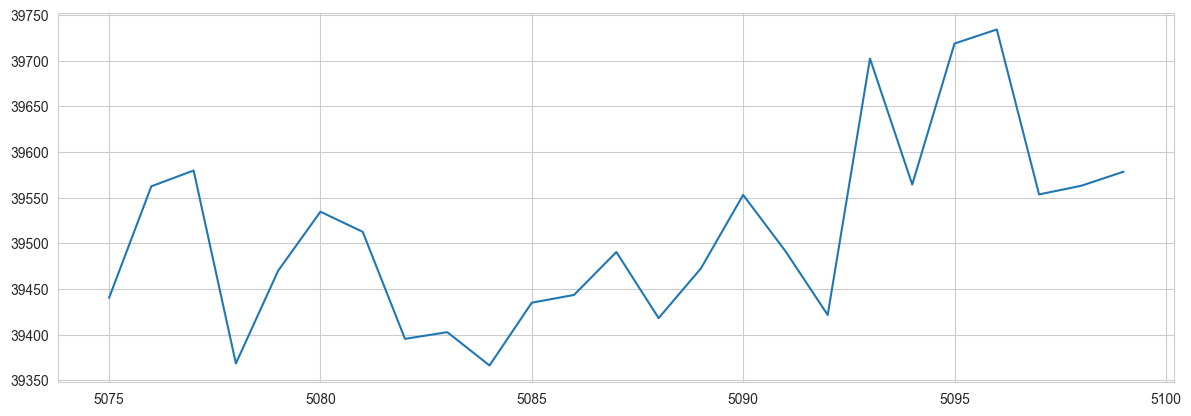

In [82]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
ax.plot(np_pred['y'][5075:5100], label='y_true')
plt.show()

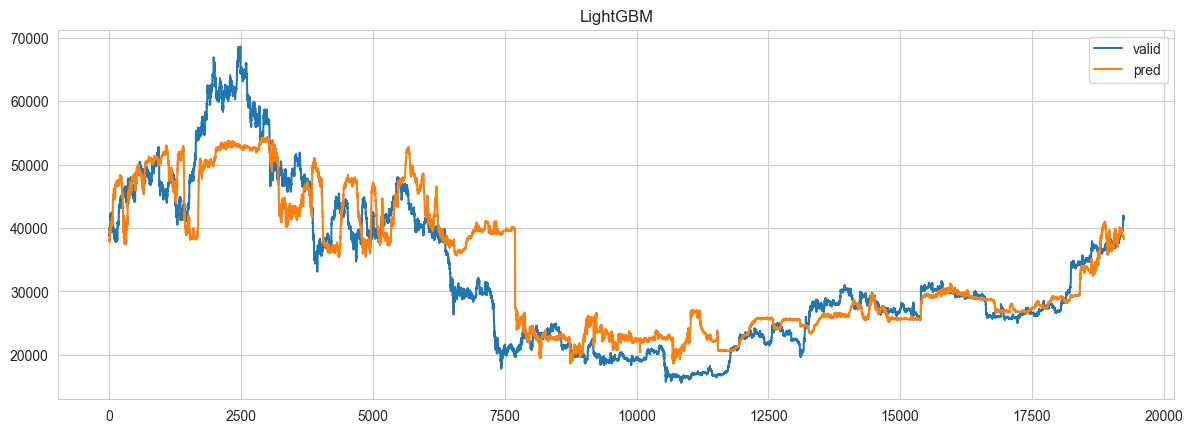

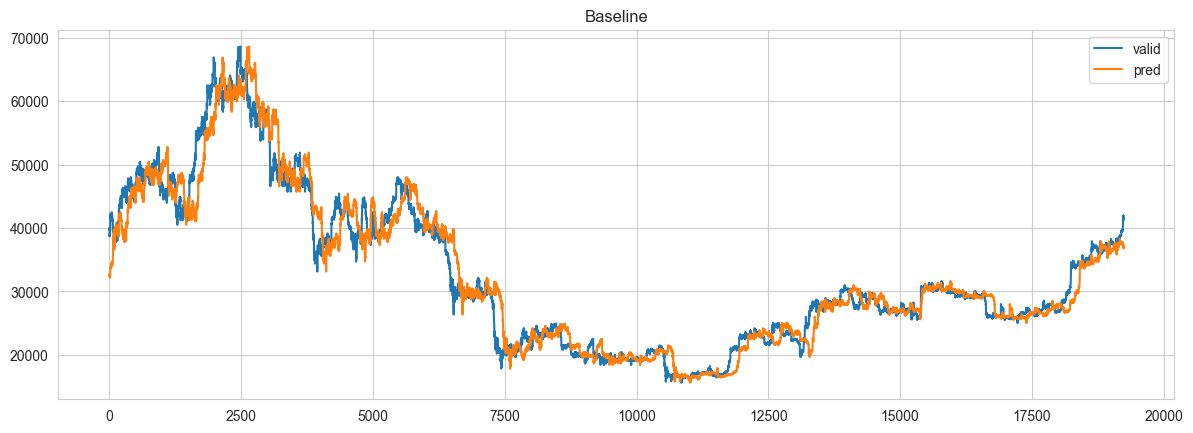

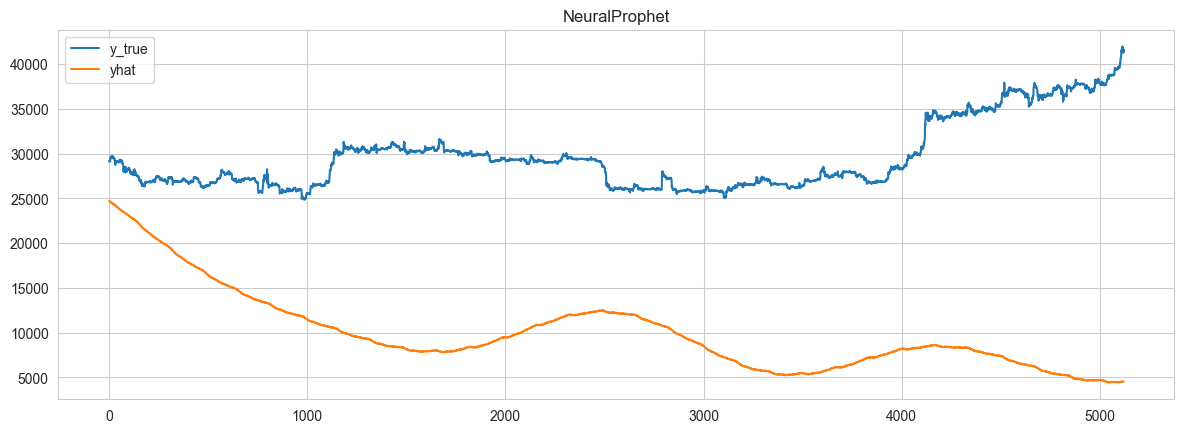

In [75]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
ax.plot(oof_valid, label='valid')
ax.plot(oof_pred, label='pred')
ax.legend()
plt.title(f"LightGBM")
plt.show()

fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
ax.plot(y_val_baseline, label='valid')
ax.plot(y_pred_baseline, label='pred')
ax.legend()
plt.title(f"Baseline")
plt.show()

fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
ax.plot(np_pred['y'], label='y_true')
ax.plot(np_pred['yhat1'], label='yhat')
ax.legend()
plt.title(f"NeuralProphet")
plt.show()

In [38]:
oof_valid[-5:]

[41753.48, 41644.94, 41270.33, 41610.027, 41589.977]

In [39]:
df_proc.iloc[-len(oof_valid):]['target'].values == oof_valid

array([False, False, False, ...,  True,  True,  True])

In [40]:
pred = np.array(oof_pred)
valid = np.array(oof_valid)
len_data = len(pred)
mean_pred = pred.mean()
mean_valid = valid.mean()
var_pred = pred.var(dtype=np.float32)
var_valid = valid.var(dtype=np.float32)

cov = np.sum((pred * valid)) / len_data - mean_pred * mean_valid
corr = cov / np.sqrt(var_pred * var_valid)
corr,cov

(0.9004289589317316, 112670387.49386072)

In [41]:
var_pred, var_valid

(106995620.0, 146337180.0)

In [42]:
type(np.array(oof_valid)[0])

numpy.float32

In [43]:
np.array(oof_valid).var(dtype=np.float32)

146337180.0

In [44]:
pred.var(), valid.var()

(106995615.01607303, 146337180.0)

In [45]:
np.square(pred - mean_valid)

array([27763173.62498883, 32054303.82835343, 30329726.42576243, ...,
       35219431.20625952, 32424788.97577543, 30630026.82154284])

In [46]:
var_pred, var_valid

(106995620.0, 146337180.0)